# MSCS 634 – Final Project (Deliverable 4)<br>
**Course:** MSCS-634 Advanced Big Data and Data Mining<br>
**Student:** <br>Pabitra Bhandari<br>Haeri Kyoung<br>Vamsi Krishna Gajulapalli<br>Prakash Tamang<br>
**Dataset Used:** Online Retail II (2009–2010)<br>


## 1. Introduction<br>
This project analyzes the **Online Retail II** transaction dataset to demonstrate an end-to-end data mining workflow. The goal is to convert raw transactional data into practical business insights using:<br>
• **Data Cleaning & EDA** (understanding patterns and data quality)<br>
• **Regression** (predicting transaction value)<br>
• **Classification** (identifying high-value customers)<br>
• **Clustering** (customer segmentation)<br>
• **Association Rule Mining** (frequently co-purchased products)<br><br>
The final output includes clear visualizations, model evaluation metrics, and recommendations aligned with real-world retail decision-making.


## 2. Dataset Description<br>
**Dataset:** Online Retail II (Excel)<br>
**Why chosen:** It is a realistic, high-volume retail dataset with product, customer, and time-based fields—ideal for regression, classification, clustering, and pattern mining.<br><br>
**Key columns:** Invoice, StockCode, Description, Quantity, InvoiceDate, Price/UnitPrice, CustomerID, Country.


In [1]:
# ============================================================
# Environment Setup (run once)
# ============================================================
import sys

# Install packages only if missing (safe to re-run)
!{sys.executable} -m pip install -q pandas numpy matplotlib seaborn openpyxl scikit-learn mlxtend

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


  You can safely remove it manually.
  You can safely remove it manually.


## 3. Data Loading, Cleaning, and Preparation<br>
The raw dataset contains missing values (CustomerID/Description), duplicate rows, returns (negative Quantity), and invalid pricing. Cleaning ensures we model **valid purchase behavior** only.


In [2]:
# ============================================================
# Step 3.1: Load dataset
# ============================================================
df_raw = pd.read_excel("online_retail_II.xlsx")

print("Raw dataset shape (rows, cols):", df_raw.shape)
display(df_raw.head())

# ============================================================
# Step 3.2: Standardize column names
# ============================================================
df_raw.columns = df_raw.columns.str.strip().str.replace(" ", "")

# Some dataset versions use 'Price' instead of 'UnitPrice'
if "UnitPrice" not in df_raw.columns and "Price" in df_raw.columns:
    df_raw = df_raw.rename(columns={"Price": "UnitPrice"})

# ============================================================
# Step 3.3: Clean dataset
# - drop missing CustomerID/Description
# - remove duplicates
# - remove returns (Quantity <= 0)
# - remove invalid pricing (UnitPrice <= 0)
# - ensure InvoiceDate is datetime
# ============================================================
df_clean = df_raw.dropna(subset=["CustomerID", "Description"]).drop_duplicates()
df_clean = df_clean[(df_clean["Quantity"] > 0) & (df_clean["UnitPrice"] > 0)]

df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"], errors="coerce")
df_clean = df_clean.dropna(subset=["InvoiceDate"])

print("Cleaned dataset shape:", df_clean.shape)
display(df_clean.head())

# ============================================================
# Step 3.4: Feature: transaction revenue
# ============================================================
df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["UnitPrice"]


Raw dataset shape (rows, cols): (525461, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Cleaned dataset shape: (400916, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 4. Exploratory Data Analysis (EDA)<br>
EDA helps validate assumptions and reveals patterns such as skewed revenue distribution, sales concentration by country, and seasonality across months.


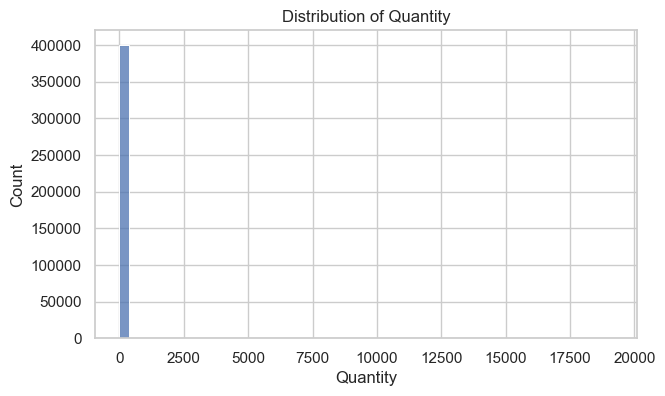

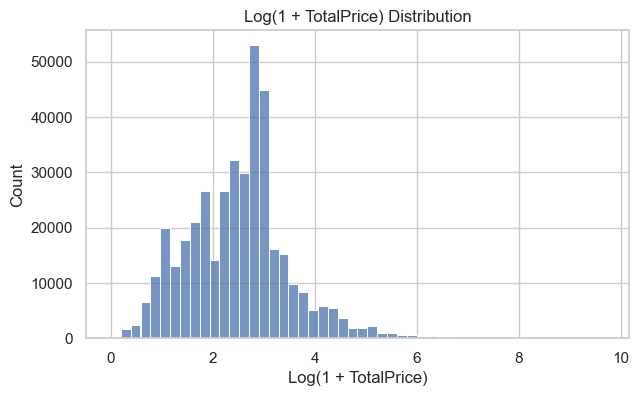

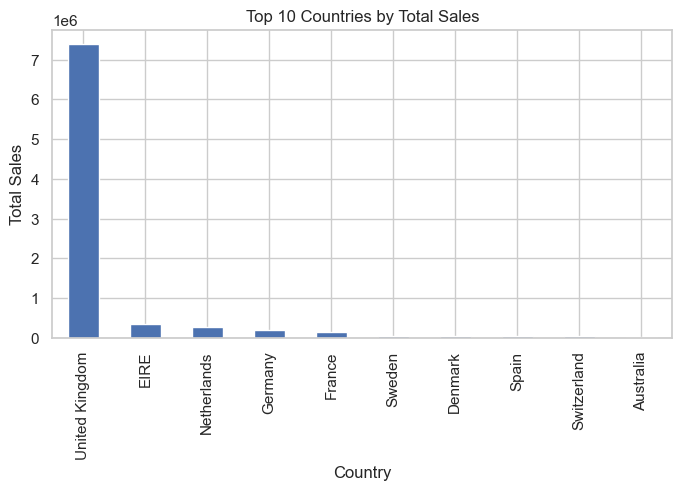

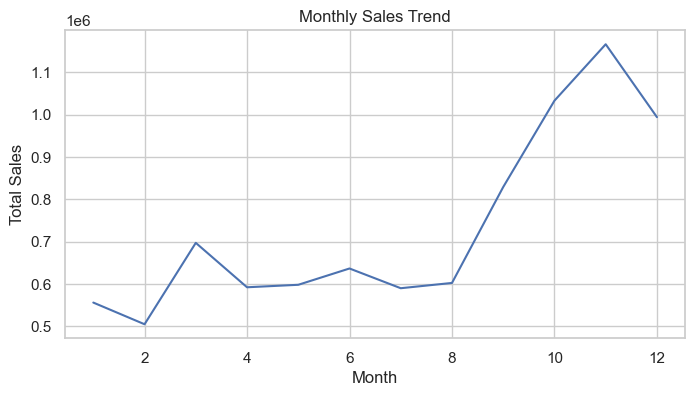

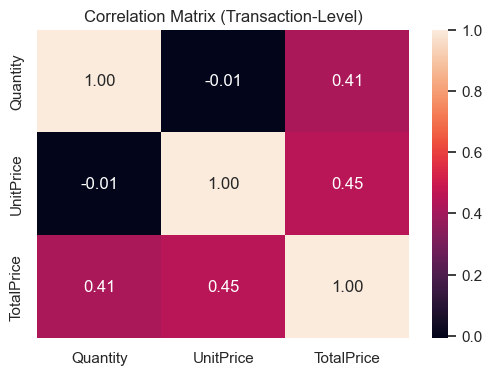

In [3]:
# ============================================================
# EDA 4.1: Quantity distribution
# ============================================================
plt.figure(figsize=(7,4))
sns.histplot(df_clean["Quantity"], bins=50)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity")
plt.show()

# ============================================================
# EDA 4.2: Log(1 + TotalPrice) distribution (reduces skew)
# ============================================================
plt.figure(figsize=(7,4))
sns.histplot(np.log1p(df_clean["TotalPrice"]), bins=50)
plt.title("Log(1 + TotalPrice) Distribution")
plt.xlabel("Log(1 + TotalPrice)")
plt.show()

# ============================================================
# EDA 4.3: Top 10 countries by total sales
# ============================================================
country_sales = df_clean.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
country_sales.plot(kind="bar")
plt.title("Top 10 Countries by Total Sales")
plt.ylabel("Total Sales")
plt.show()

# ============================================================
# EDA 4.4: Monthly sales trend (seasonality)
# ============================================================
df_clean["Month"] = df_clean["InvoiceDate"].dt.month
monthly_sales = df_clean.groupby("Month")["TotalPrice"].sum().sort_index()

plt.figure(figsize=(8,4))
monthly_sales.plot()
plt.title("Monthly Sales Trend")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.show()

# ============================================================
# EDA 4.5: Correlation among numeric transaction features
# ============================================================
plt.figure(figsize=(6,4))
sns.heatmap(df_clean[["Quantity","UnitPrice","TotalPrice"]].corr(), annot=True, fmt=".2f")
plt.title("Correlation Matrix (Transaction-Level)")
plt.show()


## 5. Feature Engineering<br>
We add time-based features and a log-transformed target for stable learning. We also add invoice-level behavioral features to represent basket diversity and basket size.


In [4]:
# ============================================================
# Step 5.1: Time-based features
# ============================================================
df_clean["Year"] = df_clean["InvoiceDate"].dt.year
df_clean["DayOfWeek"] = df_clean["InvoiceDate"].dt.dayofweek  # Monday=0
df_clean["Hour"] = df_clean["InvoiceDate"].dt.hour

# Log transform of revenue (target for regression)
df_clean["LogTotalPrice"] = np.log1p(df_clean["TotalPrice"])

# ============================================================
# Step 5.2: Invoice-level behavioral features
# ============================================================
df_clean["InvoiceUniqueItems"] = df_clean.groupby("Invoice")["StockCode"].transform("nunique")
df_clean["InvoiceTotalQuantity"] = df_clean.groupby("Invoice")["Quantity"].transform("sum")

display(df_clean[["Invoice","StockCode","Quantity","InvoiceUniqueItems","InvoiceTotalQuantity","LogTotalPrice"]].head())


,Invoice,StockCode,Quantity,InvoiceUniqueItems,InvoiceTotalQuantity,LogTotalPrice
0,489434,85048,12,8,166,4.435567
1,489434,79323P,12,8,166,4.406719
2,489434,79323W,12,8,166,4.406719
3,489434,22041,48,8,166,4.623010
4,489434,21232,24,8,166,3.433987


## 6. Regression Modeling (Predict Transaction Value)<br>
**Goal:** Predict **LogTotalPrice** (log-transformed revenue per transaction line) using transaction + time + basket features.<br><br>
Models used:<br>
• Linear Regression (baseline)<br>
• Ridge Regression (regularized)


In [5]:
# ============================================================
# Step 6.1: Build feature matrix X and target y
# ============================================================
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Target
y_reg = df_clean["LogTotalPrice"]

# Features (drop leakage/unused fields)
X_reg = df_clean.drop(columns=["TotalPrice", "LogTotalPrice", "InvoiceDate"])

# Remove free-text column (baseline regression)
if "Description" in X_reg.columns:
    X_reg = X_reg.drop(columns=["Description"])

# Ensure categorical columns are strings for OneHotEncoder
num_cols = X_reg.select_dtypes(include="number").columns.tolist()
cat_cols = X_reg.select_dtypes(exclude="number").columns.tolist()

X_reg = X_reg.copy()
for c in cat_cols:
    X_reg[c] = X_reg[c].astype(str)

print("Regression X shape:", X_reg.shape)
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Preprocessing: scale numeric + one-hot encode categorical
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# ============================================================
# Step 6.2: Train Linear Regression
# ============================================================
lr_model = Pipeline(steps=[("prep", preprocess), ("model", LinearRegression())])
lr_model.fit(X_train, y_train)
pred_lr = lr_model.predict(X_test)

rmse_lr = mean_squared_error(y_test, pred_lr) ** 0.5
r2_lr = r2_score(y_test, pred_lr)

# ============================================================
# Step 6.3: Train Ridge Regression
# ============================================================
ridge_model = Pipeline(steps=[("prep", preprocess), ("model", Ridge(alpha=1.0))])
ridge_model.fit(X_train, y_train)
pred_ridge = ridge_model.predict(X_test)

rmse_ridge = mean_squared_error(y_test, pred_ridge) ** 0.5
r2_ridge = r2_score(y_test, pred_ridge)

# ============================================================
# Step 6.4: Cross-validation (RMSE)
# ============================================================
cv_lr = cross_val_score(lr_model, X_reg, y_reg, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
cv_ridge = cross_val_score(ridge_model, X_reg, y_reg, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

cv_rmse_lr = (-cv_lr.mean()) ** 0.5
cv_rmse_ridge = (-cv_ridge.mean()) ** 0.5

results_reg = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression"],
    "Test RMSE": [rmse_lr, rmse_ridge],
    "Test R^2": [r2_lr, r2_ridge],
    "CV RMSE": [cv_rmse_lr, cv_rmse_ridge],
})

display(results_reg)


Regression X shape: (400916, 12)
Numeric cols: ['Quantity', 'UnitPrice', 'CustomerID', 'Month', 'Year', 'DayOfWeek', 'Hour', 'InvoiceUniqueItems', 'InvoiceTotalQuantity']
Categorical cols: ['Invoice', 'StockCode', 'Country']


,Model,Test RMSE,Test R^2,CV RMSE
0,Linear Regression,0.524816,0.724233,0.880113
1,Ridge Regression,0.523507,0.725607,0.854627


## 7. Classification (High-Value Customer Prediction)<br>
We aggregate transactions to the customer level (RFM-style features). High-value customers are defined as customers whose total spending is in the **top 25%**. We then train models to classify high-value customers based on behavioral features.


HighValue distribution:


HighValue
0    3234
1    1078
Name: count, dtype: int64

Train shape: (3234, 5) Test shape: (1078, 5)
LogReg Accuracy: 0.8849721706864564
LogReg F1: 0.751004016064257


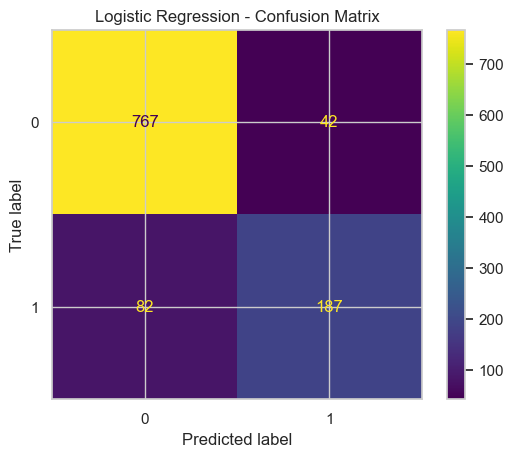

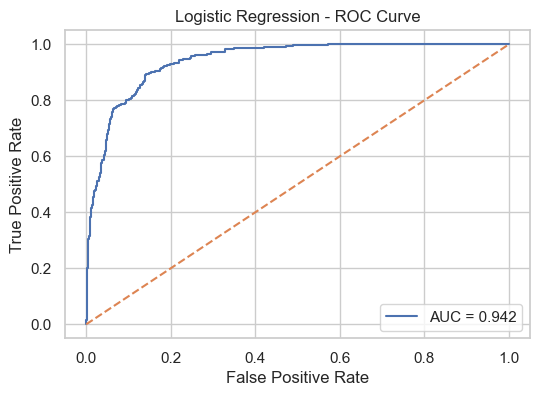

Best RF params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV F1: 0.866523702997002
Tuned RF Accuracy: 0.9183673469387755
Tuned RF F1: 0.8301158301158301


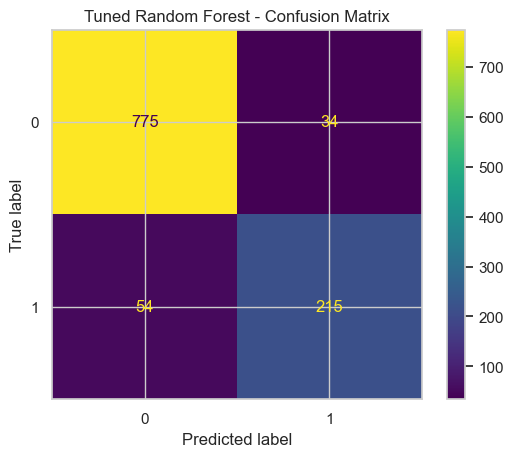

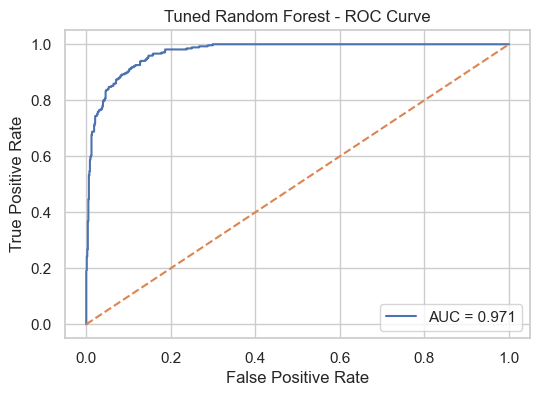

In [6]:
# ============================================================
# Step 7.1: Customer-level feature construction (RFM-style)
# ============================================================
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, f1_score, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Use a snapshot date for Recency calculation
snapshot_date = df_clean["InvoiceDate"].max() + pd.Timedelta(days=1)

cust = df_clean.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
    Frequency=("Invoice", "nunique"),
    Monetary=("TotalPrice", "sum"),
    AvgUnitPrice=("UnitPrice", "mean"),
    AvgQuantity=("Quantity", "mean"),
    UniqueProducts=("StockCode", "nunique"),
).reset_index()

# Label: HighValue = top 25% by Monetary
threshold = cust["Monetary"].quantile(0.75)
cust["HighValue"] = (cust["Monetary"] >= threshold).astype(int)

print("HighValue distribution:")
display(cust["HighValue"].value_counts())

# IMPORTANT NOTE (avoids leakage):
# Since HighValue is defined using Monetary, we exclude Monetary from predictors.
features_cls = ["Recency", "Frequency", "AvgUnitPrice", "AvgQuantity", "UniqueProducts"]
X_cls = cust[features_cls]
y_cls = cust["HighValue"]

X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.25, random_state=42, stratify=y_cls
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ============================================================
# Step 7.2: Logistic Regression baseline
# ============================================================
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, random_state=42))
])

lr_pipe.fit(X_train, y_train)
lr_pred = lr_pipe.predict(X_test)
lr_proba = lr_pipe.predict_proba(X_test)[:, 1]

print("LogReg Accuracy:", accuracy_score(y_test, lr_pred))
print("LogReg F1:", f1_score(y_test, lr_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, lr_pred)).plot()
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, lr_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression - ROC Curve")
plt.legend()
plt.show()

# ============================================================
# Step 7.3: Random Forest + hyperparameter tuning
# ============================================================
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 6, 12],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_rf = grid.best_estimator_

print("Best RF params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

rf_pred = best_rf.predict(X_test)
rf_proba = best_rf.predict_proba(X_test)[:, 1]

print("Tuned RF Accuracy:", accuracy_score(y_test, rf_pred))
print("Tuned RF F1:", f1_score(y_test, rf_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, rf_pred)).plot()
plt.title("Tuned Random Forest - Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, rf_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Tuned Random Forest - ROC Curve")
plt.legend()
plt.show()


## 8. Clustering (Customer Segmentation)<br>
K-Means clustering is used to segment customers based on RFM-style behavioral features. PCA is used for a 2D visualization of clusters.


Cluster counts:


Cluster
2    2892
0    1066
1     354
Name: count, dtype: int64

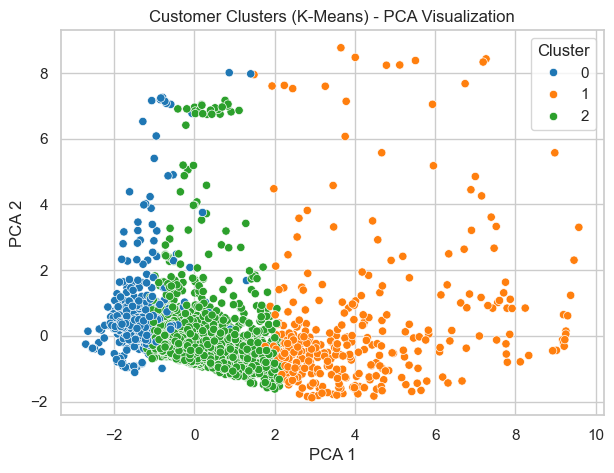

,Recency,Frequency,Monetary,AvgUnitPrice,AvgQuantity,UniqueProducts,HighValue
Cluster,,,,,,,
0,237.83,1.58,524.05,4.68,16.18,23.78,0.04
1,20.23,16.28,8800.61,3.40,30.41,202.26,1.00
2,45.75,3.58,1199.97,3.15,14.77,58.57,0.24


In [7]:
# ============================================================
# Step 8.1: Prepare data for clustering
# - To reduce the effect of extreme outliers, we clip each feature at the 1st/99th percentiles.
# ============================================================
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

cluster_features = ["Recency", "Frequency", "Monetary", "AvgUnitPrice", "AvgQuantity", "UniqueProducts"]

cust_cluster = cust.copy()
for col in cluster_features:
    low, high = cust_cluster[col].quantile([0.01, 0.99])
    cust_cluster[col] = cust_cluster[col].clip(lower=low, upper=high)

X_scaled = StandardScaler().fit_transform(cust_cluster[cluster_features])

# ============================================================
# Step 8.2: Fit KMeans (k=3 is a reasonable baseline; adjust if needed)
# ============================================================
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cust_cluster["Cluster"] = kmeans.fit_predict(X_scaled)

print("Cluster counts:")
display(cust_cluster["Cluster"].value_counts())

# ============================================================
# Step 8.3: PCA visualization (2D)
# ============================================================
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=cust_cluster["Cluster"], palette="tab10")
plt.title("Customer Clusters (K-Means) - PCA Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# Cluster profile table
cluster_profile = cust_cluster.groupby("Cluster")[cluster_features + ["HighValue"]].mean().round(2)
display(cluster_profile)


## 9. Association Rule Mining (Market Basket Analysis)<br>
We apply the Apriori algorithm to discover products that are frequently purchased together. To keep computation practical, we limit the analysis to **United Kingdom** transactions.


Basket shape (invoices x products): (17612, 4001)
Frequent itemsets: 947


,support,itemsets
588,0.165796,(85123A)
585,0.089939,(85099B)
335,0.085964,(22423)
80,0.074211,(21212)
518,0.071542,(84879)
86,0.070293,(21232)
19,0.067397,(20725)
165,0.064558,(21754)
47,0.058824,(21034)
527,0.058029,(84991)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
499,(22748),(22746),0.015274,0.011583,0.010845,0.710037,61.299876,1.0,0.010668,3.408771,0.998944,0.677305,0.706639,0.823156
498,(22746),(22748),0.011583,0.015274,0.010845,0.936275,61.299876,1.0,0.010668,15.452628,0.995214,0.677305,0.935286,0.823156
496,(22745),(22748),0.013627,0.015274,0.012321,0.904167,59.197708,1.0,0.012113,10.275405,0.996689,0.743151,0.902680,0.855429
497,(22748),(22745),0.015274,0.013627,0.012321,0.806691,59.197708,1.0,0.012113,5.102583,0.998356,0.743151,0.804021,0.855429
493,(22699),(22697),0.015444,0.013968,0.011526,0.746324,53.431911,1.0,0.011311,3.886968,0.996677,0.644444,0.742730,0.785763
492,(22697),(22699),0.013968,0.015444,0.011526,0.825203,53.431911,1.0,0.011311,5.632576,0.995185,0.644444,0.822461,0.785763
386,(22300),(22301),0.014819,0.014933,0.011072,0.747126,50.031904,1.0,0.010851,3.895492,0.994754,0.592705,0.743293,0.744286
387,(22301),(22300),0.014933,0.014819,0.011072,0.741445,50.031904,1.0,0.010851,3.810331,0.994869,0.592705,0.737556,0.744286
220,(21240),(21239),0.016125,0.016182,0.011526,0.714789,44.171436,1.0,0.011265,3.449435,0.993380,0.554645,0.710097,0.713535
221,(21239),(21240),0.016182,0.016125,0.011526,0.712281,44.171436,1.0,0.011265,3.419564,0.993437,0.554645,0.707565,0.713535


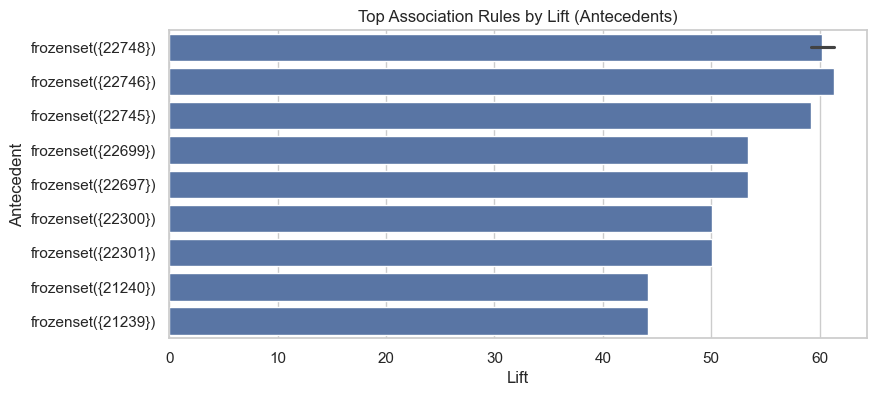

In [8]:
# ============================================================
# Step 9.1: Build basket matrix (UK only)
# ============================================================
from mlxtend.frequent_patterns import apriori, association_rules

df_rules = df_clean[df_clean["Country"] == "United Kingdom"].copy()

basket = (df_rules
          .groupby(["Invoice", "StockCode"])["Quantity"]
          .sum()
          .unstack(fill_value=0))

# Convert counts to boolean (bought/not bought)
basket = basket > 0

print("Basket shape (invoices x products):", basket.shape)

# ============================================================
# Step 9.2: Frequent itemsets
# ============================================================
freq_items = apriori(basket, min_support=0.01, use_colnames=True)
print("Frequent itemsets:", freq_items.shape[0])
display(freq_items.sort_values("support", ascending=False).head(10))

# ============================================================
# Step 9.3: Association rules (sorted by Lift)
# ============================================================
rules = association_rules(freq_items, metric="lift", min_threshold=1.2)
rules = rules.sort_values(["lift", "confidence"], ascending=False)

display(rules.head(10))

# Quick visualization: top 10 rules by lift
top_rules = rules.head(10).copy()
plt.figure(figsize=(9,4))
sns.barplot(x=top_rules["lift"], y=top_rules["antecedents"].astype(str))
plt.title("Top Association Rules by Lift (Antecedents)")
plt.xlabel("Lift")
plt.ylabel("Antecedent")
plt.show()


## 10. Key Findings & Practical Recommendations<br>
**Regression:** Ridge Regression slightly improved generalization and provides a stable approach for forecasting transaction value.<br><br>
**Classification:** Behavioral features (recency, frequency, pricing patterns, product diversity) help identify high-value customers for retention and targeted marketing.<br><br>
**Clustering:** Customer segments enable differentiated strategies such as loyalty rewards for frequent buyers and win-back offers for at-risk customers.<br><br>
**Association Rules:** Frequently co-purchased items support bundling, cross-selling, and recommendation systems.


## 11. Ethical Considerations<br>
This project uses customer identifiers (CustomerID) that are not direct personal identifiers, but ethical handling is still required.<br><br>
**Privacy:** Analysis is performed on anonymized IDs and aggregated patterns. No attempt is made to re-identify individuals.<br>
**Bias & representativeness:** Sales are heavily concentrated in the United Kingdom; insights may not generalize to other regions or time periods.<br>
**Fairness:** Predictive models should not be used to unfairly exclude customers from services. Any business action should include human oversight and transparency.<br>
**Mitigation steps:** Aggregation at customer level, excluding sensitive attributes, and cautious interpretation of model outputs.


## 12. Conclusion & Future Improvements<br>
By combining EDA, regression, classification, clustering, and association mining, this project demonstrates how big data techniques produce actionable retail insights.<br><br>
**Future improvements:** incorporate richer text features from product descriptions, test additional models (e.g., gradient boosting), and evaluate stability across time (train on earlier months, test on later months).
